# Import modules

In [1]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader


reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Plugins(categories=["generic"]).list()

assert device.type == 'cuda'


/home/bv292/miniconda/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data and settings

In [3]:
from DGE_data import get_real_and_synthetic
from DGE_utils import get_folder_names


datasets = ['adult', 'moons', 'circles','seer', 'covid', 'breast_cancer'] 
model_name = 'ctgan_deep'  # synthetic data model
    
p_train = 0.8  # proportion of training data for generative model. Default values if None
n_models = 10  # number of models in ensemble

load = True  # results
load_syn = True # data
save = True  # save results and data
max_n = 5000

verbose = False




Index(['age', 'psa', 'comorbidities', 'treatment', 'grade', 'stage', 'target'], dtype='object')


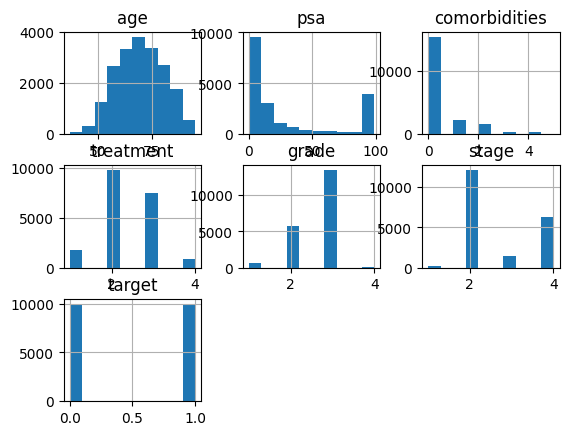

In [76]:
from DGE_data import load_real_data

dataset = 'seer'
X = load_real_data(dataset=dataset, max_n=max_n).dataframe()

a = X.hist()
print(X.columns)


In [43]:
occur = X.groupby(['MEDICAL_UNIT']).size()
print((occur.loc[4]+occur.loc[12])/occur.sum()*100)
print(occur[1])




87.99
2


In [72]:
from synthcity.utils import reproducibility

dataset = 'seer'
print('Dataset:', dataset)
nsyn = 5000
max_n = 5000
model_name = 'ctgan_deep'
X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                p_train=p_train,
                                n_models=n_models,
                                model_name=model_name,
                                load_syn=load_syn,
                                verbose=verbose,
                                max_n=max_n,
                                nsyn=nsyn)


nsyn = len(X_syns[0])
workspace_folder, results_folder = get_folder_names(dataset=dataset, model_name=model_name, nsyn=nsyn, max_n=max_n)
print('Shape of each synthetic dataset:', X_syns[0].shape)
print('Target type:', X_gt.targettype)



reproducibility.enable_reproducible_results(seed=2023)


Dataset: seer
n_total 20000 n_train: 5000
Shape of each synthetic dataset: (5000, 7)
Target type: classification


In [73]:
from DGE_utils import tt_predict_performance

models = []
model_real = None
model_type = 'xgboost'

X_test_r = X_gt.test()
X_test_r.targettype = X_gt.targettype
X_train_r = X_gt.train()
X_train_r.targettype = X_gt.targettype
scores_TRTR, model_real = tt_predict_performance(X_test_r, X_train_r, model=model_real, model_type = model_type)

scores_TSTS = [0]*len(X_syns)
scores_TSTR = [0]*len(X_syns)

for i, X_syn in enumerate(X_syns):
    X_test, X_train = X_syn.test(), X_syn.train()
    X_test.targettype = X_train.targettype = X_gt.targettype
    if len(models)==len(X_syns):
        model = models[i]
    else:
        model = None
    
    scores_TSTS[i], model = tt_predict_performance(X_test, X_train, model=model, model_type = model_type)
    scores_TSTR[i], _ = tt_predict_performance(X_test_r, X_train, model=model)
            
    models.append(model)        

scores_TSTR = pd.concat(scores_TSTR, axis=0)
scores_TSTS = pd.concat(scores_TSTS, axis=0)
        


<Figure size 400x400 with 0 Axes>

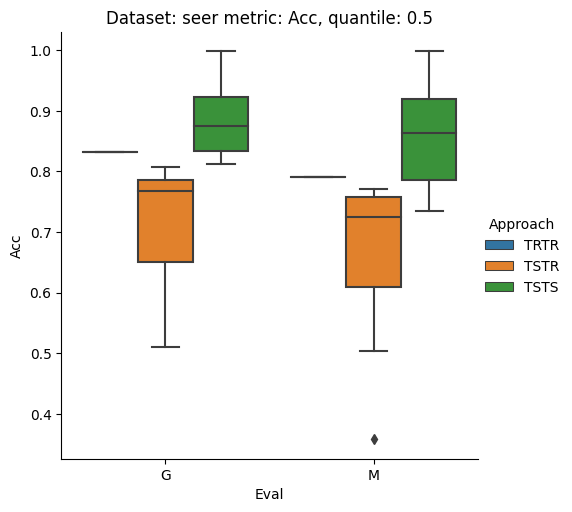

<Figure size 400x400 with 0 Axes>

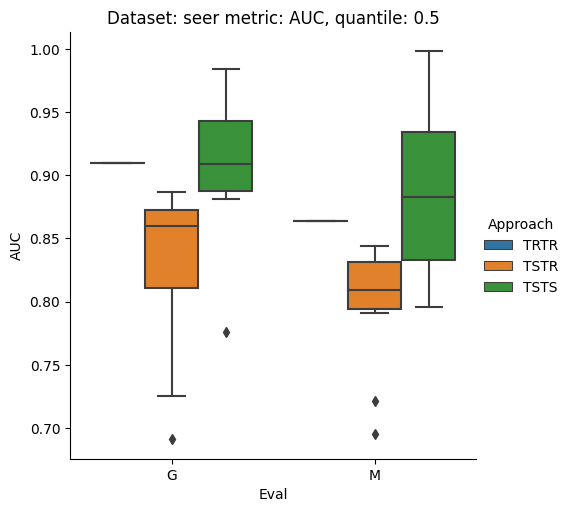

<Figure size 400x400 with 0 Axes>

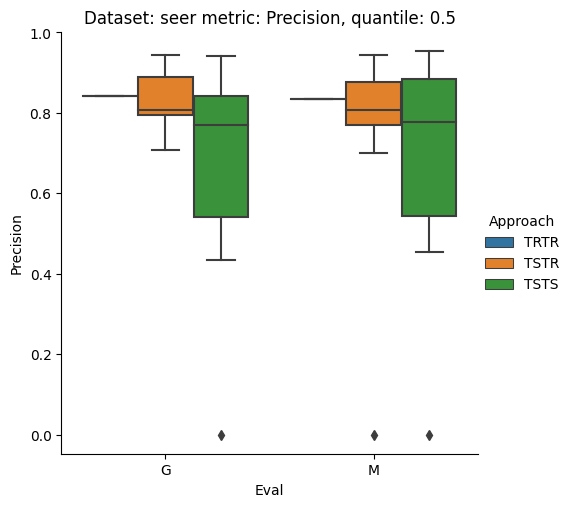

<Figure size 400x400 with 0 Axes>

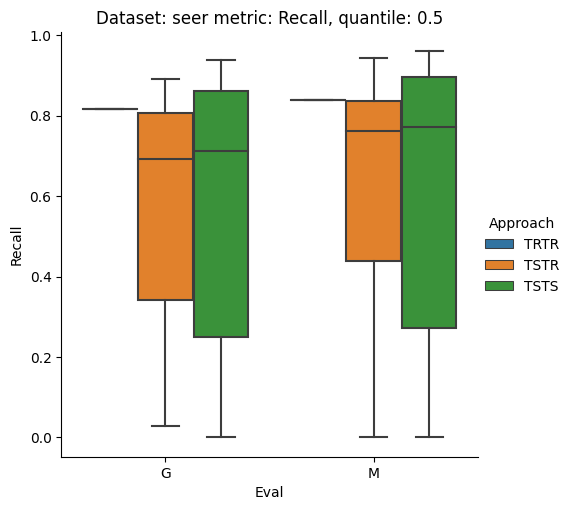

In [84]:


for quantile in [0.5]: #X['MEDICAL_UNIT'].unique()]:
    
    scores_TSTR_minority = [0]*len(X_syns)
    scores_TSTS_minority = [0]*len(X_syns)
    if dataset in ['moons', 'circles']:
        center = X_test_r.unpack(as_numpy=True)[0].mean(axis=0)
        print(center)
        dis_to_center = lambda x: np.sum((x.unpack(as_numpy=True)[0]-center)**2,axis=1)
        threshold = np.quantile(dis_to_center(X_test_r), quantile)
        minority = lambda x: x[dis_to_center(x)>threshold]
    elif dataset in ['covid']:
        #threshold = X_test_r.data.AGE.quantile(quantile)
        #minority = lambda x: x[x.data.AGE>threshold]
        minority = lambda x: x[(x['MEDICAL_UNIT']==quantile)]
        #minority = lambda x: x[(x['MEDICAL_UNIT']!=12) & (x['MEDICAL_UNIT']!=4)]
        #minority = lambda x: x[x.data.DIABETES==1]
    elif dataset in ['seer']:
        threshold = X_train_r.data.age.quantile(quantile)
        minority = lambda x: x[x.data.age>threshold]
    elif dataset=='adult':
        threshold = X_test_r.data['native.country'].mean()
        minority = lambda x: x[x.data['native.country']< threshold]
    elif dataset=='breast_cancer':
        threshold = X_test_r.data['mean radius'].quantile(1-quantile)
        minority = lambda x: x[x.data['mean radius']<threshold]


    X_test_r_minority = minority(X_test_r)
    X_test_r_minority = GenericDataLoader(X_test_r_minority, target_column='target')
    X_test_r_minority.targettype = X_gt.targettype

    try:

        scores_TRTR_minority, _ = tt_predict_performance(X_test_r_minority, X_train_r, model=model_real, model_type = model_type)
        for i, X_syn in enumerate(X_syns):
            X_test, X_train = X_syn.test(), X_syn.train()
            X_test.targettype = X_train.targettype = X_gt.targettype
            X_test_s_minority = minority(X_test)
            X_test_s_minority = GenericDataLoader(X_test_s_minority, target_column='target')
            X_test_s_minority.targettype = X_gt.targettype
            model = models[i]
            scores_TSTS_minority[i], _ = tt_predict_performance(X_test_s_minority, X_train, model=model, model_type = model_type)
            scores_TSTR_minority[i], _ = tt_predict_performance(X_test_r_minority, X_train, model=model, model_type = model_type)
            

        scores_TSTR_minority = pd.concat(scores_TSTR_minority, axis=0)
        scores_TSTS_minority = pd.concat(scores_TSTS_minority, axis=0)

        scores_TRTR = pd.DataFrame(scores_TRTR)
        scores_TRTR['Approach'] = 'TRTR'
        scores_TSTR = pd.DataFrame(scores_TSTR)
        scores_TSTR['Approach'] = 'TSTR'
        scores_TSTS = pd.DataFrame(scores_TSTS)
        scores_TSTS['Approach'] = 'TSTS'
        scores_TRTR_minority = pd.DataFrame(scores_TRTR_minority)
        scores_TRTR_minority['Approach'] = 'TRTR'
        scores_TSTR_minority = pd.DataFrame(scores_TSTR_minority)
        scores_TSTR_minority['Approach'] = 'TSTR'
        scores_TSTS_minority = pd.DataFrame(scores_TSTS_minority)
        scores_TSTS_minority['Approach'] = 'TSTS'
        df = pd.concat([scores_TRTR, scores_TSTR, scores_TSTS],axis=0)
        df['Eval'] = 'G'
        df_min = pd.concat([scores_TRTR_minority, scores_TSTR_minority, scores_TSTS_minority],axis=0)
        df_min['Eval'] = 'M'
        df = pd.concat([df, df_min],axis=0)

        for metric in ['Acc', 'AUC', 'Precision', 'Recall']:    
            import matplotlib.pyplot as plt
            import seaborn as sns

            plt.figure(figsize=(4,4), tight_layout=True)
            sns.catplot(df, x='Eval', y=metric, hue='Approach', kind='box')
            name = f'Dataset: {dataset} metric: {metric}, quantile: {quantile}'
            filename_plot = f'{dataset}_{quantile}_{metric}.png'
            plt.title(name)
            #plt.savefig(f'temp/{filename_plot}')
            plt.show()
    except KeyError:
        continue


<AxesSubplot: >

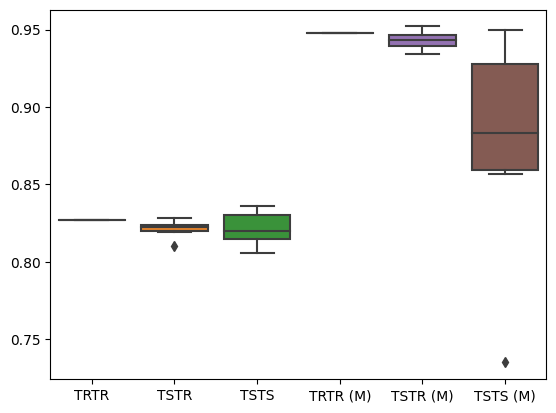

In [28]:
metric= 'Precision'
df = pd.concat([scores_TRTR[metric], scores_TSTR[metric], scores_TSTS[metric], scores_TRTR_minority[metric], scores_TSTR_minority[metric], scores_TSTS_minority[metric]],axis=1)
df.columns = ['TRTR','TSTR', 'TSTS', 
                'TRTR (M)','TSTR (M)','TSTS (M)']
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(df)
sns.title('Dataset: '+dataset)
plt.show()


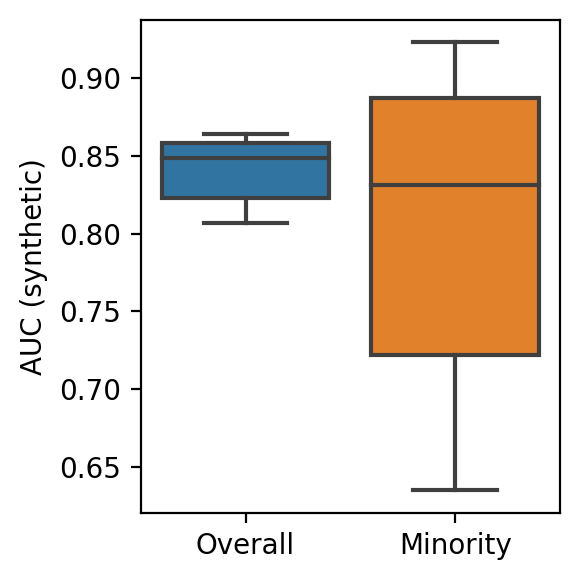

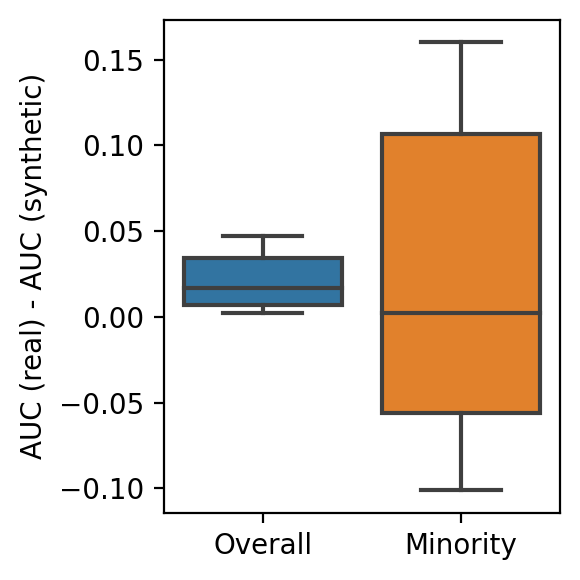

In [42]:
metric= 'AUC'
plotting = sns.boxplot
#plotting = lambda x: seaborn.violinplot(x, cut=0)
df2 = df[['TSTS', 'TSTS (M)']]
df2.columns = ['Overall', 'Minority']
plt.figure(figsize=(3,3), dpi=200, tight_layout=True)
plotting(df2)
plt.ylabel('AUC (synthetic)')
plt.savefig(results_folder+'_AUC_synthetic.png')
plt.show()
plt.figure(figsize=(3,3), dpi=200, tight_layout=True)
X = df[['TSTR','TSTR (M)']].to_numpy()-df[['TSTS', 'TSTS (M)']].to_numpy()

X = pd.DataFrame(X, columns= ['Overall', 'Minority'])
plt.ylabel('AUC (real) - AUC (synthetic)')
plotting(X)
plt.savefig(results_folder+'_AUC_real_minus_synthetic.png')

(50, 2)

In [117]:
from DGE_utils import tt_predict_performance

from synthcity.utils import reproducibility

dataset = 'seer'
print('Dataset:', dataset)
nsyn = 2000
max_n = 2000
dfs = []
flag = True

for num_layers, model_name in zip([1,2,3],['ctgan_shallow', 'ctgan', 'ctgan_deep']):
    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                    p_train=p_train,
                                    n_models=n_models,
                                    model_name=model_name,
                                    load_syn=load_syn,
                                    verbose=verbose,
                                    max_n=max_n,
                                    nsyn=nsyn)


    nsyn = len(X_syns[0])
    workspace_folder, results_folder = get_folder_names(dataset=dataset, model_name=model_name, nsyn=nsyn, max_n=max_n)
    print('Shape of each synthetic dataset:', X_syns[0].shape)
    print('Target type:', X_gt.targettype)

    

    reproducibility.enable_reproducible_results(seed=2023)
    X_test_r = X_gt.test()
    X_test_r.targettype = X_gt.targettype
    X_train_r = X_gt.train()
    X_train_r.targettype = X_gt.targettype
    
    if flag:
        oracle = tt_predict_performance(X_test_r, X_train_r, model=model_real, model_type = model_type)[0]
        flag = False
    
    models = []
    model_real = None
    model_type = 'rf'

    
    scores_TSTS = [0]*len(X_syns)
    scores_TSTR = [0]*len(X_syns)
    
    for i, X_syn in enumerate(X_syns):
        X_test, X_train = X_syn.test(), X_syn.train()
        X_test.targettype = X_train.targettype = X_gt.targettype
        if len(models)==len(X_syns):
            model = models[i]
        else:
            model = None
        
        scores_TSTS[i], model = tt_predict_performance(X_test, X_train, model=model, model_type = model_type)
        scores_TSTR[i], _ = tt_predict_performance(X_test_r, X_train, model=model)
                
        models.append(model)        

    scores_TSTR = pd.concat(scores_TSTR, axis=0)
    scores_TSTS = pd.concat(scores_TSTS, axis=0)

    scores_TSTR = pd.DataFrame(scores_TSTR)
    scores_TSTR['Approach'] = 'TSTR'
    scores_TSTS = pd.DataFrame(scores_TSTS)
    scores_TSTS['Approach'] = 'TSTS'
    df = pd.concat([scores_TSTR, scores_TSTS],axis=0)
    df['Hidden layers'] = num_layers
    dfs.append(df)



Dataset: seer
n_total 20000 n_train: 2000
Shape of each synthetic dataset: (2000, 7)
Target type: classification
n_total 20000 n_train: 2000
Shape of each synthetic dataset: (2000, 7)
Target type: classification
n_total 20000 n_train: 2000
Shape of each synthetic dataset: (2000, 7)
Target type: classification


In [98]:
oracle[metric]

0    0.899
Name: AUC, dtype: float64

TypeError: boxplot() got an unexpected keyword argument 'fig'

<Figure size 900x900 with 0 Axes>

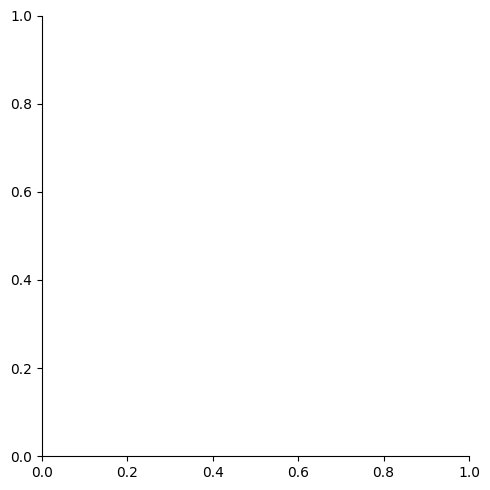

In [127]:
metric = 'Acc'

df = pd.concat(dfs, axis=0)
df.rename(columns={'Hidden layers':'CTGAN hidden layers'}, inplace=True)
fig = plt.figure(figsize=(3,3), dpi=300, tight_layout=True)
sns.catplot(fig=fig, data=df, x='CTGAN hidden layers', y=metric, hue='Approach', kind='box', showfliers = False)
# plot a horizontal line at oracle performance
#plt.axhline(float(oracle[metric]), color='black', linestyle='--', label='TRTR')
os.makedirs('uncertainty_results/stories', exist_ok=True)
plt.savefig('uncertainty_results/stories/intro_example.png', dpi=300)

In [111]:
df

,AUC,Acc,F1,Precision,Recall,NLL,Brier,Approach,Hidden layers
0,0.881,0.804,0.806,0.799,0.814,0.679,0.141,TSTR,1
0,0.883,0.805,0.807,0.801,0.813,0.618,0.139,TSTR,1
0,0.882,0.794,0.807,0.757,0.864,0.688,0.145,TSTR,1
0,0.880,0.799,0.792,0.822,0.763,0.625,0.142,TSTR,1
0,0.881,0.803,0.795,0.827,0.766,0.764,0.142,TSTR,1
0,0.882,0.805,0.808,0.794,0.823,0.607,0.140,TSTR,1
0,0.885,0.802,0.807,0.788,0.826,0.664,0.139,TSTR,1
0,0.881,0.801,0.793,0.825,0.763,0.587,0.141,TSTR,1
0,0.884,0.798,0.805,0.776,0.836,0.672,0.142,TSTR,1
0,0.871,0.789,0.777,0.827,0.732,0.589,0.148,TSTR,1
